In [1]:
try:
    import scipy
except ImportError:
    !pip install scipy
    import scipy

try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets
    import ipywidgets

try:
    import papermill
except ImportError:
    !pip install papermill
    import papermill

try:
    import plotly
except ImportError:
    !pip install plotly
    import plotly
import plotly.io as pio
pio.renderers.default = 'notebook'

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import butter, filtfilt

import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from pathlib import Path

from plotly.subplots import make_subplots
import plotly.graph_objects as go


# butterworth filter the data to clean the spikes
from scipy.signal import butter, filtfilt, argrelextrema

from pathlib import Path

In [2]:
# Experiment parameters and thresholds
frame_rate = 300 # Hz
position_threshold = 40 # mm
velocity_threshold = -0.035 # mm/s
acceleration_threshold = 0 # mm/s^2
# jerk_threshold = 0 # mm/s^3

### Threshold guidelines?
- possibly use relative threshold based on body weight? 
- perhaps an absolute threshold of velocity zero crossing is good enough 
- visual inspection? Kinda tedious. 

In [3]:
#pickle_path = Path(r"C:\Users\miken\DATA\ARGP\SAMPLE_ARGP_DATA\2022-08-29_Pilot_Data0002\generic_skelly_dict.pkl")
pickle_path = Path(r"/Users/mdn/Documents/DATA/ARGP/Pilot/demo_data_argp_analysis_Oct2022/2022-08-29_Pilot_Data0002/generic_skelly_dict.pkl")

In [4]:
# open the saved file and load the dictionary using pickle
with open(pickle_path, 'rb') as f:
    generic_skelly_dict = pickle.load(f)


In [5]:
# Listing out the keys in the dictionary for reference 
key_anatomical_points = list(generic_skelly_dict.keys())
print(key_anatomical_points)

['head_center_xyz', 'head_top_xyz', 'head_front_xyz', 'head_left_xyz', 'head_right_xyz', 'left_wrist_xyz', 'right_wrist_xyz', 'left_hand_xyz', 'right_hand_xyz', 'left_shoulder_xyz', 'right_shoulder_xyz', 'cspine_xyz', 'left_elbow_xyz', 'right_elbow_xyz', 'left_knee_xyz', 'right_knee_xyz', 'left_ankle_xyz', 'right_ankle_xyz', 'left_foot_xyz', 'right_foot_xyz', 'left_heel_xyz', 'right_heel_xyz', 'left_hip_xyz', 'right_hip_xyz', 'left_eyeball_center_xyz', 'right_eyeball_center_xyz']


In [6]:
# Extract the heel data from the dictionary
left_heel_data = generic_skelly_dict['left_heel_xyz']
right_heel_data = generic_skelly_dict['right_heel_xyz']
head_top_xyz = generic_skelly_dict['head_top_xyz']


# extract the x,y,z coordinates from the heel data
left_heel_x = left_heel_data[:,0]
left_heel_y = left_heel_data[:,1]
left_heel_z = left_heel_data[:,2]

right_heel_x = right_heel_data[:,0]
right_heel_y = right_heel_data[:,1]
right_heel_z = right_heel_data[:,2]

In [7]:
print(len(left_heel_data))
print(left_heel_data)


33436
[[ 893.249  938.807   33.246]
 [ 893.139  938.795   33.18 ]
 [ 893.292  939.111   33.928]
 ...
 [ 984.456 1042.061   34.145]
 [ 984.491 1042.095   34.107]
 [ 984.456 1042.014   34.037]]


In [8]:
# Create a time vector
def create_time_vector(left_heel_data, frame_rate): # Could have used any key in the dictionary here
    time_vector = np.arange(0, len(left_heel_data)/frame_rate, 1/frame_rate)
    return time_vector

time_vector = create_time_vector(left_heel_data, frame_rate)


print(len(time_vector))

33436


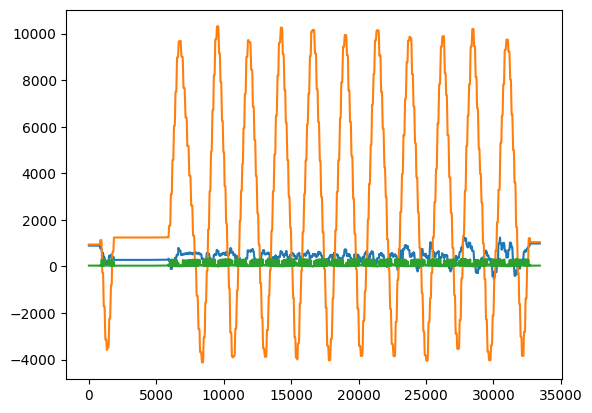

In [9]:
plt.plot(left_heel_data)
plt.show()

In [ ]:
# Create a subplots object
fig = make_subplots(rows=1, cols=1)

# Add a line trace to the subplots object with the left_heel_data Y position
fig.add_trace(go.Scatter(y = left_heel_data[:,1], mode="lines+markers", name="Left Heel Data"))

# ayout
fig.update_layout(
    title="Left Heel Data - y Position",
    xaxis_title="Time",
    yaxis_title="Z position (mm)",
    legend_title="Legend"
)

# Show the plot
fig.show()

In [ ]:
# filter the data to clean the spikes in derived data
def butterworth_filter(data, cutoff, frame_rate, order=4, filter_type='low'):
    nyq = 0.5 * frame_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    
    # Adjust the padlen based on the length of the data
    padlen = min(order * 3, len(data) - 1)
    
    y = filtfilt(b, a, data, padlen=padlen)  
    return y 


In [ ]:
# Filter parameters
cutoff_frequency = 10 # Hz
frame_rate = 300 # Hz
filter_order = 4 # Filter order

filtered_left_heel_z = butterworth_filter(left_heel_z, cutoff_frequency, frame_rate, order=filter_order)
filtered_right_heel_z = butterworth_filter(right_heel_z, cutoff_frequency, frame_rate, order=filter_order)

In [ ]:
# Calculate the velocity and acceleration from position data
def calculate_velocity_acceleration_jerk(position_data, frame_rate):
    velocity_data = np.diff(position_data) / frame_rate
    acceleration_data = np.diff(velocity_data) / frame_rate
    jerk_data = np.diff(acceleration_data) / frame_rate
    return velocity_data, acceleration_data, jerk_data

In [ ]:

def find_heel_strikes(velocity_data, position_data, acceleration_data,
                      velocity_threshold, position_threshold,
                      acceleration_threshold):
    heel_strike_indices = []
    data_length = len(velocity_data)
    
    for i in range(1, data_length - 1):  # Adjust the range to avoid index errors
        # Check for local minima below the threshold
        if (velocity_data[i] < velocity_threshold and
            velocity_data[i] < velocity_data[i - 1] and
            velocity_data[i] < velocity_data[i + 1]):
            # Look in the next 75 frames
            for j in range(i+1, min(i+76, data_length)):
                if position_data[j] < position_threshold and acceleration_data[j] > acceleration_threshold:
                    heel_strike_indices.append(j)
                    break  # Exit inner loop once the heel strike is found

    return heel_strike_indices


In [ ]:



#     return heel_strike_indices
#     heel_strike_indices = []
#     for i in range(len(velocity_data)-1):  # Adjust the range to avoid index errors
#         if velocity_data[i] < velocity_threshold and acceleration_data[i] > acceleration_threshold:
#             heel_strike_indices.append(i+1)  # Add 1 to the index 
# return heel_strike_indices


In [ ]:
# Calculate acceleration to for find_heel_strikes_using_peaks function

left_velocity, left_acceleration, left_jerk = calculate_velocity_acceleration_jerk(filtered_left_heel_z, frame_rate)
right_velocity, right_acceleration, right_jerk = calculate_velocity_acceleration_jerk(filtered_right_heel_z, frame_rate)



In [ ]:
# # Call the function for both heel and right heel position data (VELOCITY)
# left_heel_strikes_indices = find_heel_strikes_velocity_acceleration_jerk(filtered_left_heel_z, frame_rate, position_threshold, acceleration_threshold)
# right_heel_strikes_indices = find_heel_strikes_velocity_acceleration_jerk(filtered_right_heel_z, frame_rate, position_threshold, acceleration_threshold)


# Call the function for both left and right heel position data
left_heel_strikes_indices = find_heel_strikes(left_velocity, filtered_left_heel_z, left_acceleration, velocity_threshold, position_threshold, acceleration_threshold)
right_heel_strikes_indices = find_heel_strikes(right_velocity, filtered_right_heel_z, right_acceleration, velocity_threshold, position_threshold, acceleration_threshold)

In [ ]:
# Get the heel strike times using the time vector
left_heel_strikes_times = time_vector[left_heel_strikes_indices]
right_heel_strikes_times = time_vector[right_heel_strikes_indices]

# Create a dictionary with left and right heel strikes
heel_strikes_dict = {
    'left': {
        'indices': left_heel_strikes_indices,
        'times': left_heel_strikes_times,
        'positions': left_heel_data[left_heel_strikes_indices]
    },
    'right': {
        'indices': right_heel_strikes_indices,
        'times': right_heel_strikes_times,
        'positions': right_heel_data[right_heel_strikes_indices]
    }
}



In [ ]:
print(heel_strikes_dict['right']['times'])

In [ ]:
print(len(heel_strikes_dict['right']['times']))

In [ ]:
r_heel_strike = list(heel_strikes_dict['right'].keys())
print(r_heel_strike)

### I want to check if the "positions" actually hold the correct values compared to the debug plot below

In [ ]:
# debug plot to see if anything is actually showing 

left_heel_z_velocity, left_heel_z_acceleration, left_heel_z_jerk = calculate_velocity_acceleration_jerk(filtered_left_heel_z, frame_rate)

left_index_times = heel_strikes_dict['left']['times']
left_index_positions = heel_strikes_dict['left']['positions']
left_index_positions_z = left_index_positions[:,2]

# Plot the left heel's z-axis velocity and acceleration data

time_vector_zv = time_vector[:-1] # Adjust the time vector to match the velocity and acceleration data
time_vector_za = time_vector[:-2] 
time_vector_zj = time_vector[:-3]



# Create a subplots object with 4 rows and 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Left heel Z position plot
fig.add_trace(
    go.Scatter(
        x=time_vector, y=filtered_left_heel_z,
        mode="lines", name="Left heel Z position", line=dict(color="yellow")
    ),
    row=1, col=1
)

fig.add_shape(
    type="line", x0=min(time_vector), x1=max(time_vector), y0=40, y1=40,
    yref="y1", xref="x1", line=dict(color="red", dash="dash")
)

fig.add_trace(
    go.Scatter(
        x=left_index_times, y=left_index_positions_z,
        mode="markers", marker=dict(color="blue", symbol="x"),
        name="Left Heel Strikes"
    ),
    row=1, col=1
)

# Left heel Z velocity plot
fig.add_trace(
    go.Scatter(
        x=time_vector_zv, y=left_heel_z_velocity,
        mode="lines", name="Left heel Z velocity", line=dict(color="blue")
    ),
    row=2, col=1
)

fig.add_shape(
    type="line", x0=min(time_vector_zv), x1=max(time_vector_zv), y0=-0.035, y1=-0.035,
    yref="y2", xref="x2", line=dict(color="red", dash="dash")
)

# Left heel Z acceleration plot
fig.add_trace(
    go.Scatter(
        x=time_vector_za, y=left_heel_z_acceleration,
        mode="lines", name="Left heel Z acceleration"
    ),
    row=3, col=1
)

fig.add_shape(
    type="line", x0=min(time_vector_za), x1=max(time_vector_za), y0=0, y1=0,
    yref="y3", xref="x3", line=dict(color="red", dash="dash")
)


# Update layout
fig.update_layout(
    title="Left Heel Data",
    xaxis=dict(range=[80, 100], title="Time (s)"),
    yaxis1=dict(title="Position"),
    yaxis2=dict(title="Velocity"),
    yaxis3=dict(title="Acceleration"),
)

# Show the plot
fig.show()

In [ ]:
def find_trial_indices(data, start_frame, comparator, order=1):
    trial_indices = argrelextrema(data, comparator, order=order)
    trial_indices = trial_indices[0][trial_indices[0] >= start_frame]
    return trial_indices


In [ ]:
import numpy as np
from scipy.signal import savgol_filter

def segment_trials(data_xyz: np.ndarray, window_length: int, polyorder: int, consistency_threshold: int):

    assert window_length % 2 == 1, "Window length must be odd"

    trial_dict = {}
    trial_num = 0
    trial_start = None

    # Apply a Savitzky-Golay filter to smooth the y-coordinate data
    y_smooth = savgol_filter(data_xyz[:, 1], window_length, polyorder)

    # Compute the derivative of the smoothed y-coordinate data
    y_velocity = np.gradient(y_smooth)



    potential_sign_change_frame = None

    for frame_number in range(1, data_xyz.shape[0]):
        # Check if the derivative has changed sign
        if y_velocity[frame_number] * y_velocity[frame_number-1] < 0:
            # Mark the current frame as a potential sign change
            potential_sign_change_frame = frame_number
        elif potential_sign_change_frame is not None:
            # Check if we've had a consistent sign for consistency_threshold frames since the potential sign change
            if all(np.sign(y_velocity[i]) == np.sign(y_velocity[potential_sign_change_frame]) for i in range(potential_sign_change_frame, frame_number)):
                if frame_number - potential_sign_change_frame >= consistency_threshold:
                    if trial_start is not None:
                        trial_dict[trial_num] = (trial_start, potential_sign_change_frame - 1)
                        trial_num += 1
                    # Start a new trial
                    trial_start = potential_sign_change_frame
                    # Reset potential_sign_change
                    potential_sign_change_frame = None

    # Handle case where the last trial goes until the end of the data
    if trial_start is not None:
        trial_dict[trial_num] = (trial_start, data_xyz.shape[0] - 1)

    return trial_dict



In [ ]:
trial_indexes = segment_trials(head_top_xyz, 5, 3, 151)

In [ ]:
print(trial_indexes)

In [ ]:
start_trial_markers = [start for start, end in trial_indexes.values()]
end_trial_markers = [end for start, end in trial_indexes.values()]



fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(y=left_heel_data[:, 1], mode="lines", name="Y Position Data"))

fig.add_trace(go.Scatter(x=start_trial_markers,
                         y=left_heel_data[start_trial_markers, 1],
                         mode='markers',
                         marker=dict(symbol='x', size=10),
                         name='Start Trial'))

fig.add_trace(go.Scatter(x=end_trial_markers,
                         y=left_heel_data[end_trial_markers, 1],
                         mode='markers',
                         marker=dict(symbol='circle', size=10),
                         name='End Trial'))

fig.show()

In [ ]:
# # Replace with your actual start frame
# start_frame = 5000
#
# # Define the window (order) for the local maxima and minima
# order = 800
#
# # Find crest (local maxima) and trough (local minima) indices
# crest_indices = find_trial_indices(left_heel_data[:, 1], start_frame, np.greater, order)
# trough_indices = find_trial_indices(left_heel_data[:, 1], start_frame, np.less, order)
#
# print(crest_indices)
#

In [ ]:
# # Combine crest and trough indices and sort
# trial_indices = np.sort(np.concatenate((crest_indices, trough_indices)))
#
# # Create a list of trial start and stop indices
# trial_start_stop_indices = [(trial_indices[i], trial_indices[i+1]) for i in range(0, len(trial_indices)-1, 2)]
#

In [ ]:
# # Number each trial
# trial_start_stop_indices = list(enumerate(trial_start_stop_indices, start=1))
# print(trial_start_stop_indices)


In [ ]:
# start_trial_markers = []
# end_trial_markers = []
#
# for i in range(len(trial_start_stop_indices)):
#     start_trial_markers.append(trial_start_stop_indices[i][1][0])
#     end_trial_markers.append(trial_start_stop_indices[i][1][1])
#
# print(start_trial_markers)
#

In [ ]:
# print(trial_start_stop_indices[3][1][0])

In [ ]:
# fig = make_subplots(rows=1, cols=1)
#
# fig.add_trace(go.Scatter(y=left_heel_data[:, 1], mode="lines", name="Left Heel Data"))
#
# fig.add_trace(go.Scatter(x=start_trial_markers,
#                          y=left_heel_data[start_trial_markers],
#                          mode='markers',
#                          marker=dict(symbol='circle', size=10),
#                          name='Start Trial'))
#
# fig.add_trace(go.Scatter(x=end_trial_markers,
#                          y=left_heel_data[end_trial_markers],
#                          mode='markers',
#                          marker=dict(symbol='x', size=10),
#                          name='End Trial'))
#
# fig.update_layout(
#     title="Left Heel Data - y Position",
#     xaxis_title="Time",
#     yaxis_title="Z position (mm)",
#     legend_title="Legend"
# )
#
# fig.show()


In [ ]:
# # Find the indices corresponding to 40 seconds and 42 seconds
# start_time = 40
# end_time = 45
# start_index = np.argmin(np.abs(time_vector - start_time))
# end_index = np.argmin(np.abs(time_vector - end_time))
#
# # Get the data in the dictionary for the specified time range
# filtered_heel_strikes_dict = {
#     'left': {
#         'indices': [idx for idx in heel_strikes_dict['left']['indices'] if start_index <= idx <= end_index],
#         'times': heel_strikes_dict['left']['times'][(heel_strikes_dict['left']['times'] >= start_time) & (heel_strikes_dict['left']['times'] <= end_time)],
#         'positions': heel_strikes_dict['left']['positions'][(heel_strikes_dict['left']['times'] >= start_time) & (heel_strikes_dict['left']['times'] <= end_time)]
#     },
#     'right': {
#         'indices': [idx for idx in heel_strikes_dict['right']['indices'] if start_index <= idx <= end_index],
#         'times': heel_strikes_dict['right']['times'][(heel_strikes_dict['right']['times'] >= start_time) & (heel_strikes_dict['right']['times'] <= end_time)]
#     }
# }
#
#
# print(len(filtered_heel_strikes_dict['left']['indices']))